# **Goal for Round 2: ** 

This notebook tries to discover better & meaningful answers and visualizations around the following questions:

**What do we know about vaccines and therapeutics? What has been published concerning research and development and evaluation efforts of vaccines and therapeutics?**

**Effectiveness of drugs being developed and tried to treat COVID-19 patients.**

**Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.**

**Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.**

**Exploration of use of best animal models and their predictive value for a human vaccine.**

**Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.**

**Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.**

**Efforts targeted at a universal coronavirus vaccine.**

**Efforts to develop animal models and standardize challenge studies**

**Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers**

**Approaches to evaluate risk for enhanced disease after vaccination**

**Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models in conjunction with therapeutics**

# **About Us:**
We are a group of AI and NLP scientists with experience across NLP, image processing and computer vision. Covid-19 Kaggle challenge has provided us with a unique opportunity to help humanity fight the corona virus pandemic collectively by utilizing benefits of AI and NLP. We have focused on creating NLP solution to enable users to ask questions and get the most accurate results from the vast corpus of medical journals.


# **Approach:**

We have trained the sent2vec model on the most recent dump of CORD-19 corpus to generate sentence embeddings. This model is trained on 14658255 sentences and 864320 words. **Fasttext embeddings are huge in size so we could not generate this in the working directory of the kernel.** We trained our model on AWS and uploaded the same as additional dataset.

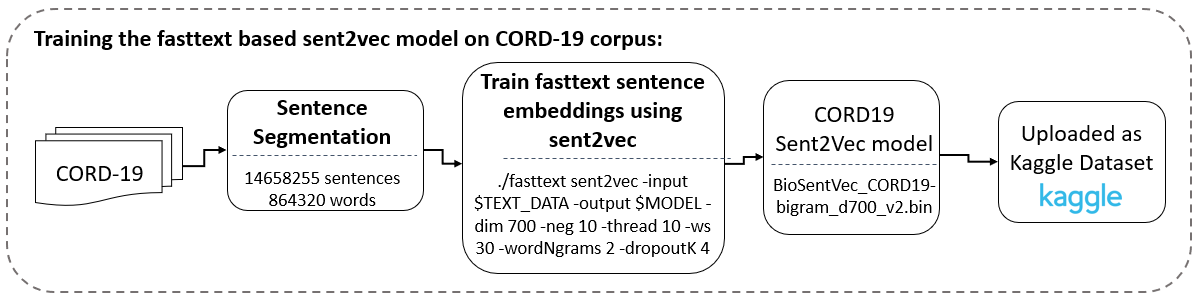

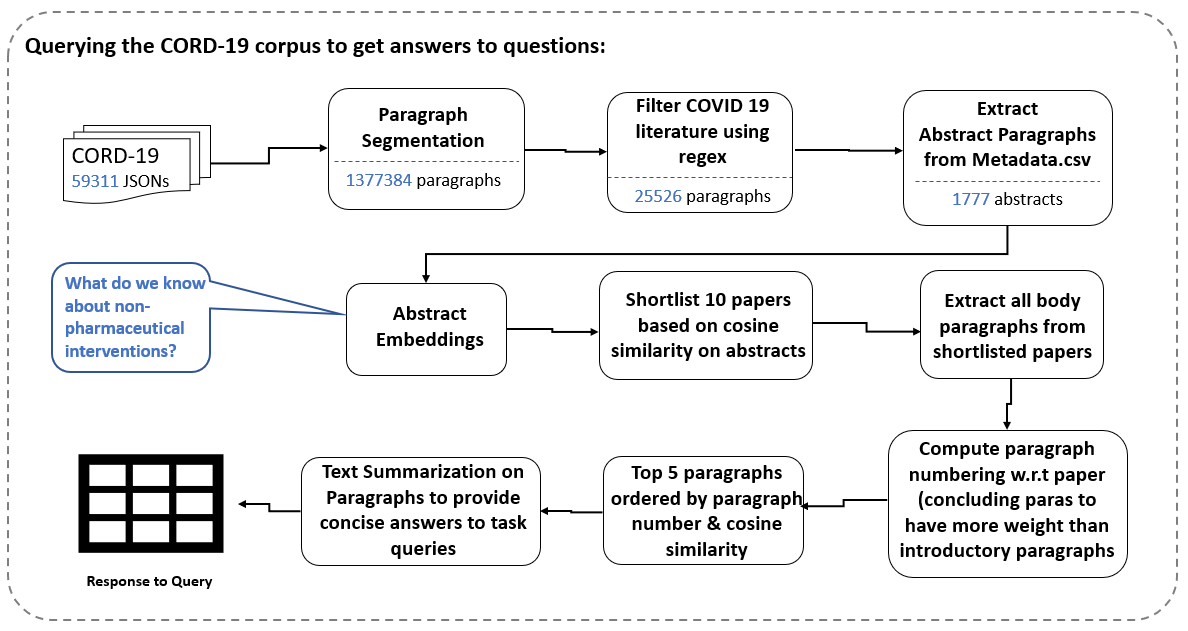

# Benefits of this approach:

* Very simple and straightforward approach without complex indexing and other dependencies which need to be set up
* Based on FastText Sent2Vec embeddings trained on CORD-19 corpus - embeddings are contextually relevant to the queries
* Filtering helps remove lots of non-covid content
* Text summarization helps to summarize longer paragraphs

# Further Improvements possible:
* Embeddings are currently computed on entire paragraphs rather than at sentence level. Aggregating sentence level embeddings at paragraph level would be more relevant
* Currently only looks for answers in papers which have abstracts available in the metadata.csv. Approach needs to be further scaled to entire literature
* Disease names can be further extracted using spacy medical NER models that can add further structure to the response

# Install and set-up dependencies

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz
!pip install scispacy
!git clone https://github.com/epfml/sent2vec.git

In [ ]:
cd sent2vec

In [ ]:
!pip install .

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import spacy
import en_core_sci_sm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import pandas as pd
from tqdm import tqdm
import re
import spacy
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None  # default='warn'

# Load the Input JSON files & metadata.csv

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

root_path = '/kaggle/input/CORD-19-research-challenge/'
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
print(len(all_json), 'JSON files detected')
metadata_path = f'{root_path}metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi': str
})
print(len(meta_df), 'files in metadata.csv')
print(meta_df.columns)
meta_df.head(3)

In [ ]:
meta_df['publish_date'] = pd.to_datetime(meta_df['publish_time'], infer_datetime_format=True)
meta_df['publish_date'].head()

In [ ]:
# 'source_x', 'license', 'journal', 'has_pdf_parse', 'has_pmc_xml_parse', 'full_text_file'
print("Source:")
print(meta_df['source_x'].value_counts(), '\n')

print("license:")
print(meta_df['license'].value_counts(), '\n')

print("Journal:")
print(meta_df['journal'].value_counts(), '\n')

print("has_pdf_parse:")
print(meta_df['has_pdf_parse'].value_counts(), '\n')

print("has_pmc_xml_parse:")
print(meta_df['has_pmc_xml_parse'].value_counts(), '\n')

print("full_text_file:")
print(meta_df['full_text_file'].value_counts(), '\n')

# Extract Abstract & Body paragraphs from JSON

In [ ]:
##### Keyword patterns to search for
keywords = [r"2019[\-\s]?n[\-\s]?cov", "2019 novel coronavirus", "coronavirus 2019", r"coronavirus disease (?:20)?19",
            r"covid(?:[\-\s]?19)?", r"n\s?cov[\-\s]?2019", r"sars-cov-?2", r"wuhan (?:coronavirus|cov|pneumonia)",
            r"rna (?:coronavirus|cov|pneumonia)", r"mers (?:coronavirus|cov|pneumonia)", r"influenza (?:coronavirus|cov|pneumonia)",
            r"sars (?:coronavirus|cov|pneumonia)", r"sars", r"mers", r"pandemic", r"pandemics"]

covid_keywords = [r"2019[\-\s]?n[\-\s]?cov", "2019 novel coronavirus", "coronavirus 2019", r"coronavirus disease (?:20)?19",
            r"covid(?:[\-\s]?19)?", r"n\s?cov[\-\s]?2019", r"sars-cov-?2", r"wuhan (?:coronavirus|cov|pneumonia)"]

# Build regular expression for each keyword. Wrap term in word boundaries
regex = "|".join(["\\b%s\\b" % keyword.lower() for keyword in keywords])
covid_regex = "|".join(["\\b%s\\b" % keyword.lower() for keyword in covid_keywords])

def tags(text):
    if re.findall(regex, str(text).lower()):
        tags = "COVID-19"
    else:
        tags="NON COVID"
    return tags

def covid_tags(text):
    if re.findall(covid_regex, str(text).lower()):
        tags = "COVID-19"
    else:
        tags="NON COVID"
    return tags


class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
        self.paper_id = content['paper_id']
        self.content = content
        self.abstracts = []
        self.body_texts = []
        self.countries = []
        self.title = ''
        
        if "abstract" in self.content:
            for idx, entry in enumerate(self.content['abstract']):
                if not isinstance(entry['text'], str):
                    continue
                d={}
                d["idx"] = idx
                d["section"] = entry['section']
                d["para"] = entry['text']
                self.abstracts.append(d)
    
        for idx,entry in enumerate(self.content['body_text']):
            if not isinstance(entry['text'], str):
                continue
            d = {}
            d["idx"] = idx
            d["section"] = entry['section']
            d["para"] = entry['text']
            self.body_texts.append(d)
    
        if "metadata" in self.content and "authors" in self.content["metadata"]:
            for idx, author in enumerate(self.content['metadata']['authors']):
                if 'affiliation' in author and 'location' in author['affiliation']:
                    location = author['affiliation']['location']
                    if 'region' in location:
                        self.countries.append(location['region'])
                    elif 'country' in location:
                        self.countries.append(location['country'])
        self.countries = list(set(self.countries))
    
        if "metadata" in self.content and "title" in self.content["metadata"]:
            self.title = self.content["metadata"]["title"]
    
    def __repr__(self):
        return f'{self.paper_id}: {self.abstracts[:2]}... {self.body_texts[:2]}... {self.countries[:]}...'

firstRow = FileReader(all_json[0])
print(firstRow.paper_id)
print(firstRow.title)
print(firstRow.countries)

Iterate JSON directories to load all the paragraphs from abstracts and body of different papers. Abstracts if available in metadata.csv is also loaded separately.

In [ ]:
no_of_files_not_found = 0
dict_ = {
    'cord_uid':[], 'paper_id': [], 'section': [], 'sub_section': [], 'paragraph': [], 'authors': [], 'title': [],
    'journal': [], 'publish_date': [], 'tags':[], 'countries': [], 'source_x': [], 'full_text_file': []
}

for index, meta in tqdm(meta_df.iterrows(), total=meta_df.shape[0]): # 
    has_pdf_parse = meta.has_pdf_parse
    has_pmc_xml_parse = meta.has_pmc_xml_parse
    
    if has_pmc_xml_parse == True:
        full_text_file_path = root_path + meta.full_text_file + '/' + meta.full_text_file + '/pmc_json/' + meta.pmcid + '.xml.json'
    elif has_pdf_parse == True:
        full_text_file_path = root_path + meta.full_text_file + '/' + meta.full_text_file + '/pdf_json/' + meta.sha + '.json'
    
    if os.path.isfile(full_text_file_path) == False:
        no_of_files_not_found += 1
        continue
    
    content = FileReader(full_text_file_path)
    
    cord_uid = meta.cord_uid
    authors = meta.authors
    title = meta.title
    journal = meta.journal
    publish_date = meta.publish_date
    source_x = meta.source_x
    full_text_file = meta.full_text_file
        
#     print('Authors : ', authors)
#     print('Title : ', title)
#     print('Journal : ', journal)
#     print('Publish Date : ', publish_date)
#     print('Journal : ', journal)
#     if len(content.countries)>0:
#         print('Countries : ', ','.join(content.countries))
        
    metadata_abstract = meta.abstract
    if isinstance(metadata_abstract, str):
        dict_['cord_uid'].append(cord_uid)
        dict_['paper_id'].append(content.paper_id)
        dict_['section'].append('Metadata Abstract')
        dict_['sub_section'].append('Metadata Abstract')
        dict_['tags'].append(tags(metadata_abstract))
        dict_['paragraph'].append(metadata_abstract)
        dict_['publish_date'].append(publish_date)
        dict_['authors'].append(authors)
        dict_['title'].append(title)
        dict_['journal'].append(journal)
        dict_['countries'].append(','.join(content.countries))
        dict_['source_x'].append(source_x)
        dict_['full_text_file'].append(full_text_file)
    
    for items in content.abstracts:
        dict_['cord_uid'].append(cord_uid)
        dict_['paper_id'].append(content.paper_id)
        dict_['section'].append('JSON Abstract')
        dict_['sub_section'].append(items['section'])
        dict_['tags'].append(tags(str(items['para'])))
        dict_['paragraph'].append(items['para'])
        dict_['publish_date'].append(publish_date)
        dict_['authors'].append(authors)
        dict_['title'].append(title)
        dict_['journal'].append(journal)
        dict_['countries'].append(','.join(content.countries))
        dict_['source_x'].append(source_x)
        dict_['full_text_file'].append(full_text_file)
        
    for items in content.body_texts:
        dict_['cord_uid'].append(cord_uid)
        dict_['paper_id'].append(content.paper_id)
        dict_['section'].append('Body')
        dict_['sub_section'].append(items['section'])
        dict_['tags'].append(tags(str(items['para'])))
        dict_['paragraph'].append(items['para'])
        dict_['publish_date'].append(publish_date)
        dict_['authors'].append(authors)
        dict_['title'].append(title)
        dict_['journal'].append(journal)
        dict_['countries'].append(','.join(content.countries))
        dict_['source_x'].append(source_x)
        dict_['full_text_file'].append(full_text_file)
        
print(no_of_files_not_found, 'files not found.')

Load metadata abstracts & body paragraphs into Dataframes

In [ ]:
import os.path
def extract_covid_abstracts_body(dict_):
    df_all = pd.DataFrame(dict_,
                        columns=['cord_uid', 'paper_id', 'section', 'sub_section', 'paragraph', 'authors', 'title',
                                 'journal', 'publish_date', 'tags', 'countries', 'source_x', 'full_text_file' ])
    print("# of All publications : ", df_all['cord_uid'].nunique())
    
    df_titles = df_all[df_all['title'].notnull() & df_all['title'] != '']
    df_na_titles = df_all[df_all['title'].isna() | df_all['title'] == '']
    
    print(df_titles['cord_uid'].nunique(), 'publications have titles')
    print(df_na_titles['cord_uid'].nunique(), 'publications have titles missing')
    
    # TODO remove duplicates
    display(df_all.head(3))
    
    df_titles = df_titles[['cord_uid', 'title', 'publish_date', 'countries', 'journal', 'source_x', 'full_text_file']].drop_duplicates()
    df_titles = df_titles.drop_duplicates(subset='title', keep='last')
    print(len(df_titles), 'unique titles selected.')
    display(df_titles.head(5))
#     # Extract only Covid articles
#     df_covid_content = df_all.loc[df_all['tags'] == 'COVID-19']
#     print("Covid19 papers : ", df_covid_content['paper_id'].nunique())
    
    df_metadata_abstracts = df_all.loc[df_all['section']=="Metadata Abstract"]
    df_json_abstracts = df_all.loc[df_all['section']=="JSON Abstract"]
    df_body = df_all.loc[df_all['section']=="Body"]
#     df_body_meta = df_body.loc[df_body.paper_id.isin(df_metadata_abstracts.paper_id.values)]
#     df_body_non_meta = df_body.loc[~df_body.paper_id.isin(df_metadata_abstracts.paper_id.values)]
    
    return df_titles, df_metadata_abstracts, df_body

df_titles, df_abstracts, df_body = extract_covid_abstracts_body(dict_)
paper_bodies = df_body.groupby(['cord_uid'])
print("Metadata unique abstracts : ", df_abstracts['paper_id'].nunique())
print("# of unique meta papers : ", df_body['paper_id'].nunique())

# df_abstracts.head()
df_abstracts['tags'].value_counts()

# Number of Titles published over time

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

df_titles.columns

In [ ]:
df_titles['month'] = df_titles["publish_date"].dt.month
df_titles['year'] = df_titles["publish_date"].dt.year

grouped_titles_by_time_source = df_titles.groupby(['year', 'month', 'full_text_file'])['title'].count()
grouped_titles_by_time_source = grouped_titles_by_time_source.reset_index()
grouped_titles_by_time_source.head()

In [ ]:
# plt.figure(figsize=(8, 5))
g = sns.catplot(x="full_text_file", kind="count", data=grouped_titles_by_time_source);
g.fig.set_figheight(4)
g.fig.set_figwidth(6)
plt.xticks(rotation=45)
plt.title('# of titles published by full_text_file')

In [ ]:
# # Summarize the number of publications
# groups_titles = df_titles.groupby(['year', 'month'])['title'].count()
# groups_titles = groups_titles.reset_index()
# groups_titles.tail()

plt.figure(figsize=(20, 5))
g = sns.relplot(x="year", y="title", kind="line", hue="full_text_file", dashes=False, markers=True, data=grouped_titles_by_time_source)
g.fig.set_figheight(5)
g.fig.set_figwidth(20)
plt.title('# of titles published over time')

# Extraction of author countries:

In [ ]:
!pip install us

In [ ]:
# COUNTRIES_LOOKUP
[c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Italy').alpha_2)]

In [ ]:
import pycountry     # package for all countries
import us # package for us states
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# countries lookup
COUNTRIES_LOOKUP = {c.name.lower():c.name for c in pycountry.countries}
CANADA_SUBDIVISIONS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Canada').alpha_2)]
INDIAN_STATES = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='India').alpha_2)]
JAPAN_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Japan').alpha_2)]
AUS_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Australia').alpha_2)]
CHINA_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='China').alpha_2)]
ENG_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='United Kingdom').alpha_2)]
COLOMBIA_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Colombia').alpha_2)]
ITALY_SUBS = [c.name for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Italy').alpha_2)]

# countries abbreviations lookup
CAN_ABR = [ c.code.replace(c.country_code+'-', '') for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Canada').alpha_2)]
AUS_ABR = [c.code.replace(c.country_code+'-', '') for c in pycountry.subdivisions.get(country_code=pycountry.countries.get(name='Australia').alpha_2)]

df_titles['countries'].replace('', "NA", inplace=True)

In [ ]:
# import time

# country_counts = []
# for auth_coun in tqdm(df_titles["countries"].values):
#     country_counts.append(len([c for c in auth_coun.split(",")]))
# df_titles['country_counts'] = country_counts
# # print(df_titles['country_counts'].value_counts())

# start_time = time.time()
# author_coun_list = df_titles.loc[df_titles['country_counts'] >= 15]['countries'].values
# not_found_list = []
# for author_couns in tqdm(author_coun_list):
#     coun_list = author_couns.split(",")
#     for coun_raw in coun_list:
        
#         coun = re.sub('[^A-Za-z\s]+', '', coun_raw).strip()
#         us_state = us.states.lookup(coun)

#         if coun == "UK":
#             coun = "United Kingdom"
#         if coun == "Ont":
#             coun = "Ontario"
        
#         fuzzy_country = process.extractOne(coun.lower(), COUNTRIES_LOOKUP.keys(), scorer=fuzz.token_set_ratio) 
#         fuzzy_canada = process.extractOne(coun.lower(), CANADA_SUBDIVISIONS, scorer=fuzz.token_set_ratio) 
#         fuzzy_india = process.extractOne(coun.lower(), INDIAN_STATES, scorer=fuzz.token_set_ratio) 
#         fuzzy_japan = process.extractOne(coun.lower(), JAPAN_SUBS, scorer=fuzz.token_set_ratio) 
#         fuzzy_australia = process.extractOne(coun.lower(), AUS_SUBS, scorer=fuzz.token_set_ratio) 
#         fuzzy_china = process.extractOne(coun.lower(), CHINA_SUBS, scorer=fuzz.token_set_ratio) 
#         fuzzy_britain = process.extractOne(coun.lower(), ENG_SUBS, scorer=fuzz.token_set_ratio) 
#         fuzzy_colombia = process.extractOne(coun.lower(), COLOMBIA_SUBS, scorer=fuzz.token_set_ratio) 
#         fuzzy_espana_score = fuzz.token_sort_ratio(coun.lower(), "españa")
        
#         normalized_country = 'lookup_match_failed'
#         if us_state or coun.lower() == "usa" or coun.lower() == "united states":
#             normalized_country = "usa"
        
#         elif coun.lower() in COUNTRIES_LOOKUP:
#             normalized_country = coun.lower()
        
#         elif coun.lower() == 'russia':
#             normalized_country = 'russian federation'
        
#         elif coun.lower() == 'vietnam':
#             normalized_country = 'vietnam'
        
#         elif coun.lower() == 'south korea'
#             normalized_country = 'south korea'
        
#         elif coun.lower() == 'roc' or coun.lower() == 'pr china' or coun.lower() == 'prchina':
#             normalized_country = 'china'
        
#         elif fuzzy_espana_score >= 85 or coun.lower() == "sp":
#             normalized_country = 'spain'
        
#         elif coun in CAN_ABR or fuzzy_canada[1] >= 85:
#             normalized_country = 'canada'
# #             print(coun, "================= fuzzy_canada ===================>", normalized_country)
        
#         elif fuzzy_country[1] >= 85:
# #             print(coun, "================= fuzzy_country ===================>", fuzzy_country[0].lower())
#             normalized_country = fuzzy_country[0].lower()
        
#         elif fuzzy_india[1] >= 85:
# #             print(coun, "================= fuzzy_india ===================>", fuzzy_india[0].lower())
#             normalized_country = 'india'
        
#         elif fuzzy_japan[1] >= 85:
# #             print(coun, "================= fuzzy_japan ===================>", fuzzy_japan[0].lower())
#             normalized_country = 'japan'
        
#         elif coun in AUS_ABR or fuzzy_australia[1] >= 85:
#             normalized_country = 'australia'
# #             print(coun, "================= fuzzy_australia ===================>", normalized_country)
        
#         elif fuzzy_china[1] >= 85:
# #             print(coun, "================= fuzzy_china ===================>", fuzzy_china[0].lower())
#             normalized_country = 'china'
        
#         elif fuzzy_britain[1] >= 85:
# #             print(coun, "================= fuzzy_britain ===================>", fuzzy_britain[0].lower())
#             normalized_country = 'united kingdom'
        
#         elif fuzzy_colombia[1] >= 85:
# #             print(coun, "================= fuzzy_colombia ===================>", fuzzy_colombia[0].lower())
#             normalized_country = 'colombia'
    
#         elif fuzzy_italy[1] >= 85:
# #             print(coun, "================= fuzzy_italy ===================>", fuzzy_italy[0].lower())
#             normalized_country = 'italy'
    
# #         elif len(coun) > 3:
# #             try:
# #                 matches = pycountry.countries.search_fuzzy(coun)
# #                 if len(matches) > 0:
# #                     normalized_country = matches[0].name.lower()
# #             except:
# # #                 print(coun, "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
# #                 not_found_list.append(coun)
    
#         else:
#             not_found_list.append(coun_raw)

#         normalized_country = "_".join(normalized_country.split(" "))
# #         print(coun, '=>', normalized_country)
# print('\n', len(set(not_found_list)), "countries not found...")
# print("time elapsed = ", time.time() - start_time, "for", len(author_coun_list), "rows")

In [ ]:
not_found_list = []
titles_normalized_countries = []
count_countries = []

for auth_coun in tqdm(df_titles["countries"].values):
    coun_list = [c.strip() for c in auth_coun.split(",")]
    
    pub_normalized_countries = []
    for coun_raw in coun_list:    
        coun = re.sub('[^A-Za-z\s]+', '', coun_raw).strip()
        us_state = us.states.lookup(coun)

        if coun == "UK":
            coun = "United Kingdom"
        if coun == "Ont":
            coun = "Ontario"
        
        fuzzy_country = process.extractOne(coun.lower(), COUNTRIES_LOOKUP.keys(), scorer=fuzz.token_set_ratio) 
        fuzzy_canada = process.extractOne(coun.lower(), CANADA_SUBDIVISIONS, scorer=fuzz.token_set_ratio) 
        fuzzy_india = process.extractOne(coun.lower(), INDIAN_STATES, scorer=fuzz.token_set_ratio) 
        fuzzy_japan = process.extractOne(coun.lower(), JAPAN_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_australia = process.extractOne(coun.lower(), AUS_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_china = process.extractOne(coun.lower(), CHINA_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_britain = process.extractOne(coun.lower(), ENG_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_colombia = process.extractOne(coun.lower(), COLOMBIA_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_italy = process.extractOne(coun.lower(), ITALY_SUBS, scorer=fuzz.token_set_ratio) 
        fuzzy_espana_score = fuzz.token_sort_ratio(coun.lower(), "españa")
        
        normalized_country = 'lookup_match_failed'
        if us_state or coun.lower() == "usa" or coun.lower() == "united states":
            normalized_country = "usa"
        
        elif coun.lower() in COUNTRIES_LOOKUP:
            normalized_country = coun.lower()
        
        elif coun.lower() == 'russia':
            normalized_country = 'russian federation'
        
        elif coun.lower() == 'vietnam':
            normalized_country = 'vietnam'
        
        elif coun.lower() == 'south korea':
            normalized_country = 'south korea'
        
        elif coun.lower() == 'roc' or coun.lower() == 'pr china' or coun.lower() == 'prchina':
            normalized_country = 'china'
        
        elif fuzzy_espana_score >= 85 or coun.lower() == "sp":
            normalized_country = 'spain'
        
        elif coun in CAN_ABR or fuzzy_canada[1] >= 85:
            normalized_country = 'canada'
#             print(coun, "================= fuzzy_canada ===================>", normalized_country)
        
        elif fuzzy_country[1] >= 85:
#             print(coun, "================= fuzzy_country ===================>", fuzzy_country[0].lower())
            normalized_country = fuzzy_country[0].lower()
        
        elif fuzzy_india[1] >= 85:
#             print(coun, "================= fuzzy_india ===================>", fuzzy_india[0].lower())
            normalized_country = 'india'
        
        elif fuzzy_japan[1] >= 85:
#             print(coun, "================= fuzzy_japan ===================>", fuzzy_japan[0].lower())
            normalized_country = 'japan'
        
        elif coun in AUS_ABR or fuzzy_australia[1] >= 85:
            normalized_country = 'australia'
#             print(coun, "================= fuzzy_australia ===================>", normalized_country)
        
        elif fuzzy_china[1] >= 85:
#             print(coun, "================= fuzzy_china ===================>", fuzzy_china[0].lower())
            normalized_country = 'china'
        
        elif fuzzy_britain[1] >= 85:
#             print(coun, "================= fuzzy_britain ===================>", fuzzy_britain[0].lower())
            normalized_country = 'united kingdom'
        
        elif fuzzy_colombia[1] >= 85:
#             print(coun, "================= fuzzy_colombia ===================>", fuzzy_colombia[0].lower())
            normalized_country = 'colombia'
        
        elif fuzzy_italy[1] >= 85:
#             print(coun, "================= fuzzy_italy ===================>", fuzzy_italy[0].lower())
            normalized_country = 'italy'
        
#         elif len(coun) > 3:
#             try:
#                 matches = pycountry.countries.search_fuzzy(coun)
#                 if len(matches) > 0:
#                     normalized_country = matches[0].name.lower()
#             except:
# #                 print(coun, "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
#                 not_found_list.append(coun)
    
        else:
            not_found_list.append(coun_raw)

        normalized_country = "_".join(normalized_country.split(" "))
        pub_normalized_countries.append(normalized_country)
    
    titles_normalized_countries.append(pub_normalized_countries)
    count_countries.append(len(pub_normalized_countries))

print('\n', len(set(not_found_list)), "countries not found...")

**Countries that were not found from look up:**

In [ ]:
# Tally occurrences of words in a list
from collections import Counter

# print(len(set(not_found_list)))

cnt = Counter()
for word in not_found_list:
    cnt[word] += 1
# cnt
sorted(cnt.items(), key=lambda item: item[1], reverse=True)

**Add the extracted normalized author countries back to titles data frame:**

In [ ]:
df_titles['normalized_countries_count'] = count_countries
df_titles['normalized_countries'] = [' '.join(list(set(c))) for c in titles_normalized_countries]
df_titles['normalized_countries'].value_counts()

**Compute the Bag-Of_words for the extracted countries using CountVectorizer:**

In [ ]:
df_titles['cord_uid'].head(5)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names, cord_uids):
    
    # create an index for each row
#     doc_names = ['Pub{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=cord_uids,
                      columns=feat_names)
    return(df)
  
# set of documents
corpora = [' '.join(list(set(c))) for c in titles_normalized_countries]

# instantiate the vectorizer object
cvec = CountVectorizer(lowercase=False, min_df=50)

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpora)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
df_country_vectors = wm2df(wm, tokens, df_titles['cord_uid'].values)
df_country_vectors.head()

In [ ]:
df_country_vectors.ix['i0zym7iq']

# Visualizing research in different countries on epidemics and pandemics:

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

no_of_pubs_by_country = df_country_vectors.sum()
no_of_pubs_by_country.sort_values(ascending=False, inplace=True)
no_of_pubs_by_country = no_of_pubs_by_country.drop(labels=['lookup_match_failed'])
no_of_pubs_by_country = no_of_pubs_by_country.head(17)

In [ ]:
ax = no_of_pubs_by_country.plot.bar(figsize=(12, 6), rot=45, title='# of titles published by top 15 countries')

In [ ]:
df_country_vectors["publish_date"] = df_titles["publish_date"].values
df_country_vectors['month'] = df_country_vectors["publish_date"].dt.month
df_country_vectors['year'] = df_country_vectors["publish_date"].dt.year

top_author_countries = list(no_of_pubs_by_country.index.values)
# top_author_countries.remove('year')
# top_author_countries.remove('month')

year_wise = df_country_vectors.groupby(['year']).sum()
year_wise = year_wise[top_author_countries]

year_wise = year_wise.ix[[2000.0, 2001.0, 2002.0, 2003.0, 2004.0,
              2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0,
              2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0
]]
year_wise
year_wise.plot(figsize=(20, 6), rot=45, title='# of titles published by top 15 countries accross years')

**In the above plot we can see USA easily leads the race in research. It has particularly picked up around 2003, which was the first SARs outbreak.**

In [ ]:
df_country_vectors["publish_date"] = df_titles["publish_date"].values
df_country_vectors['month'] = df_country_vectors["publish_date"].dt.month
df_country_vectors['year'] = df_country_vectors["publish_date"].dt.year

year_wise = df_country_vectors.groupby(['year']).sum()
coun_wise = year_wise.T
coun_wise = coun_wise[[2000.0, 2001.0, 2002.0, 2003.0, 2004.0,
              2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0,
              2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0
]]
top_author_countries = list(no_of_pubs_by_country.index.values)
# top_author_countries.remove('year')
# top_author_countries.remove('month')
# top_author_countries.remove('usa')

coun_wise = coun_wise.ix[top_author_countries]
coun_wise.plot(figsize=(20, 8), rot=90, title='# of titles published by top 15 countries in different years')
plt.xticks(range(0,len(coun_wise.index)), top_author_countries, rotation=90)

**The above plot again tries to show the RELATIVE research done by different countries in the twentieth century. We have dropped the USA since it becomes difficult to visualize the other countries!**

In [ ]:
# df_country_vectors.index = df_titles["publish_date"].values
# df_country_vectors = df_country_vectors.cumsum()
# # df_country_vectors.head()
# # df_country_vectors[['united_kingdom', 'italy']].plot(subplots=True, figsize=(6, 6)); plt.legend(loc='best')

# fig, axes = plt.subplots(nrows=2, ncols=2)

# df_country_vectors['united_kingdom'].plot(ax=axes[0,0]); axes[0,0].set_title('united_kingdom')
# df_country_vectors['italy'].plot(ax=axes[0,1]); axes[0,1].set_title('italy')
# df_country_vectors['usa'].plot(ax=axes[1,0]); axes[1,0].set_title('usa')
# df_country_vectors['china'].plot(ax=axes[1,1]); axes[1,1].set_title('china')


# # df_country_vectors[['united_kingdom', 'italy']].plot.box()

In [ ]:
# plt.figure(figsize=(20, 5))
# # g = sns.relplot(x="year", y="china", kind="line", data=coun_grps_titles)
# g = sns.lineplot(data=coun_grps_titles)
# g.fig.set_figheight(5)
# g.fig.set_figwidth(20)
# plt.title('# of titles published over time')

# g = coun_grps_titles[['year', 'united_kingdom', 'italy']].plot(x="year", figsize=(20, 5), title='# of titles published over time for countries')

In [ ]:
import gc
gc.collect()

**Load FastText sent2vec model trained on CORD-19 corpus**

In [ ]:
import sent2vec
#model_path = "/kaggle/input/biosentvec/BioSentVec_CORD19-bigram_d700.bin"
model_path = "/kaggle/input/covid-sent2vec-ver2/BioSentVec_CORD19-bigram_d700_v2.bin"
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print("model successfully loaded")

# Sub-task Queries

In [ ]:
# Vaccines
sub_tasks = [
    "What do we know about vaccines and therapeutics for COVID 19 or the novel coronavirus? What has been published concerning research and development and evaluation efforts of vaccines and therapeutics for COVID 19 or the novel coronavirus?",
    "What is the effectiveness of drugs being developed and tried (like chloroquine, arbidol, remdesivir, and favipiravir) to treat COVID-19 patients.",
    "Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
    "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients for COVID 19 or the novel coronavirus.",
    "Exploration of use of best animal models and their predictive value for a human vaccine.",
    "Capabilities to discover a therapeutic for COVID 19 or the novel coronavirus, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
    "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up for COVID 19 or the novel coronavirus. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
    "Efforts targeted at a universal coronavirus vaccine.",
    "Efforts to develop animal models and standardize challenge studies for COVID 19 or the novel coronavirus",
    "Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers for COVID 19 or the novel coronavirus",
    "Approaches to evaluate risk for enhanced disease after vaccination for COVID 19 or the novel coronavirus",
    "Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models in conjunction with therapeutics for COVID 19 or the novel coronavirus"
]
sub_tasks_names = [
    "summary",
    "drugs_efficacy",
    "bench_trials",
    "complication_ade",
    "exploration_animal_models",
    "therapeutics_efficacy",
    "alternative_models",
    "universal_coronavirus_vaccine.",
    "develop_animal_models",
    "prophylaxis_clinical_studies",
    "risk_post_vaccination",
    "vaccine_immune_response"
]

# Abstract embeddings & Plots:

**Let's analyze the available abstracts with respect to the queries for this Task:**

In [ ]:
from scipy.spatial import distance

def create_abstract_task_embeddings():
    abstract_vectors = []
    paper_cord_uids = []
    for cord_uid, abstract in tqdm(df_abstracts[["cord_uid","paragraph"]].values):
        if not isinstance(abstract, str):
            continue

        sub_tasks_vectors = []
        for sub_task in sub_tasks:
            # prepare the individual vectors of paragraphs
            embs = model.embed_sentences([abstract, sub_task])
            cosine_sim = 1 - distance.cosine(embs[0], embs[1])
            sub_tasks_vectors.append(cosine_sim)

        # compute the max of vectors to get paper vectors
        abstract_vectors.append(sub_tasks_vectors)
        paper_cord_uids.append(cord_uid)

    # store the paper vector into df
    print(len(abstract_vectors), len(df_abstracts))
    df_abstracts_vectors = pd.DataFrame(abstract_vectors, columns=sub_tasks_names)
    
    return df_abstracts_vectors

df_abstracts_vectors = create_abstract_task_embeddings()


In [ ]:
df_abstracts_vectors.describe()

**The sentence embeddings extracted for available abstracts in metadata.csv are compared with the several smaller questions around this particular tasks. The following box plot shows the match of the literature around these questions, kind off measuring the confidence levels of the answers: **

Some insights from the plot:
* **universal_coronavirus_vaccine** has the lowest mean confidence. 
    This means that for the question *"Efforts targeted at a universal coronavirus vaccine."* the answers may not be too relevant
* **alternative_models** has the highest mean confidence.
    This means that for the question *"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up for COVID 19 or the novel coronavirus. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need."* the answers will hopefully be more relevant

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df_abstracts_vectors)
plt.xticks(rotation=45)

In [ ]:
df_rounded = df_abstracts_vectors.round(0).astype(pd.Int32Dtype())
df_rounded["date"] = df_abstracts.publish_date.values
df_rounded['month'] = df_rounded["date"].dt.month
df_rounded['year'] = df_rounded["date"].dt.year

# Summarize the number of publications
groups_abs_vects = df_rounded.groupby(['year', 'month']).sum()
groups_abs_vects = groups_abs_vects.reset_index()

**Let's look at the number of published titles on "Efforts targeted at a universal coronavirus vaccine" with time:**

In [ ]:
plt.figure(figsize=(20, 5))
g = sns.relplot(x="year", y="universal_coronavirus_vaccine.", kind="line", data=groups_abs_vects)
g.fig.set_figheight(5)
g.fig.set_figwidth(20)
plt.title('# of publications on "Efforts targeted at a universal coronavirus vaccine" over time')

**We can note that there have been spurts in the research with time.**

**Now let's look at the number of published titles on "Alternative models to prioritize and distribute scarce, newly proven therapeutics" with time:**

In [ ]:
g = sns.relplot(x="year", y="alternative_models", kind="line", data=groups_abs_vects)
g.fig.set_figheight(5)
g.fig.set_figwidth(20)
plt.title('# of publications on "Alternative models to prioritize and distribute scarce, newly proven therapeutics" over time')

**We can note that there has been special interest after the occurence of the first outbreak of SARS in early 2000 and thereafter number of published titles have increased considerably**

In [ ]:
def display_time_plots(sub_task_name):
    plt.figure(figsize=(20, 5))
    g = sns.relplot(x="year", y=sub_task_name, kind="line", data=groups_abs_vects);
    g.fig.set_figheight(5)
    g.fig.set_figwidth(20)
    plt.title('# of publications over time')

In [ ]:
# # df_abstracts_indexed = df_abstracts.set_index(df_abstracts.publish_date)
# df_tsplot = df_abstracts_vectors.copy()
# # df_tsplot["date"] = df_abstracts.publish_date

# plt.figure(figsize=(20,8))

# # This plot shows the confidence level of the match between each sub_task and related content
# g = sns.boxplot(data=df_tsplot)
# plt.xticks(rotation=45)
# # g = sns.pairplot(df_tsplot)

# # g = sns.relplot(x="date", y="summary", kind="line", data=df_tsplot)

# # def display_correlation_plots_abstracts():
    
# #     corr = df_abstracts_vectors.corr()
# #     ax = sns.heatmap(
# #         corr, 
# #         vmin=-1, vmax=1, center=0,
# #         cmap=sns.diverging_palette(20, 220, n=200),
# #         square=True
# #     )
# #     ax.set_xticklabels(
# #         ax.get_xticklabels(),
# #         rotation=45,
# #         horizontalalignment='right'
# #     );

# #     g = sns.pairplot(corr)

# Title embeddings & Plots:

In [ ]:
def generate_title_embeddings():
    title_dict = {}
    titles_list = []
    title_covid_tags = []
    for cord_uid, title in tqdm(df_titles[["cord_uid","title"]].values):
        if isinstance(title, str):
            title_dict[cord_uid] = model.embed_sentence(title)
            titles_list.append(title)
            title_covid_tags.append(covid_tags(title))

    paper_ids = list(title_dict.keys())
    t_vectors = np.array(list(title_dict.values()))
    nsamples, x, y = t_vectors.shape
    titles_array = t_vectors.reshape((nsamples,x*y))
    print(titles_array.shape)
    
#     print("Computing cosine similarity matrix.....")
#     cosine_sim_matrix = cosine_similarity(titles_array, titles_array)
    
#     n_sim_articles = 3
#     input_idx = 1

#     sim_indexes = np.argsort(cosine_sim_matrix[input_idx])[::-1][1:n_sim_articles+1]
#     print("sim_indexes", sim_indexes)

#     print("-------QUERY TITLE-----")
#     print(titles_list[input_idx])
#     print()
#     print(f"----TOP {n_sim_articles} SIMILAR TITLES-----")
#     for sim_idx in sim_indexes:
#         print(titles_list[sim_idx])
#         print()
#         print("-"*50)
    
    
    return paper_ids, titles_array, titles_list, title_covid_tags

paper_ids, titles_array, titles_list, title_covid_tags = generate_title_embeddings()

# Sub-task wise document clusters & statistics (by license, author location, date, Title word cloud):

In [ ]:
def summarize_paragraph(para_text):
    doc = medical(para_text)
    
    entities_list = []
    sent_dict = {}
    sent_list = []
    for sent in doc.sents:
        sent_dict[sent.text] = model.embed_sentence(sent.text)
        sent_list.append(sent.text)
        entities_list.extend([ent.text for ent in doc.ents])

    s_vectors = np.array(list(sent_dict.values()))
    nsamples, x, y = s_vectors.shape
    sent_vectors = s_vectors.reshape((nsamples,x*y))
    cosine_sim_matrix_sents = cosine_similarity(sent_vectors, query_vector.reshape(1,-1))

    if len(sent_list) > 30:
        no_of_sents_summ = int(len(sent_list) * 0.1)
    elif len(sent_list) > 20:
        no_of_sents_summ = int(len(sent_list) * 0.2)
    elif len(sent_list) > 10:
        no_of_sents_summ = int(len(sent_list) * 0.3)
    elif len(sent_list) > 5:
        no_of_sents_summ = int(len(sent_list) * 0.4)
    else:
        no_of_sents_summ = len(sent_list)

    sent_sim_indexes = np.argsort(cosine_sim_matrix_sents.reshape(1,-1)[0])[::-1][:no_of_sents_summ]
    sents_summ = [sent_list[j] for j in sent_sim_indexes]
    return " ".join(sents_summ), entities_list

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

def get_documents_clusters_by_titles(query_statement, no_of_docs=30):
    is_COVID = covid_tags(query_statement)
    
    display(Markdown("# Query : "+query_statement))
    
    # extract the cosine similarity of query against titles
    title_sim_matrix_query = cosine_similarity(titles_array, query_vector.reshape(1,-1))
    titles_similarities = title_sim_matrix_query.reshape(1,-1)[0]*100
    
    df_publications = pd.DataFrame(list(zip(paper_ids, titles_list, titles_similarities, title_covid_tags)), 
               columns =['cord_uid', 'title', 'title_similarity', 'tag'])
    df_publications = df_publications.sort_values(by='title_similarity', ascending=False)
    
    if is_COVID == 'COVID-19':
        df_publications = df_publications.loc[df_publications['tag'] == 'COVID-19']
    
    if df_publications['title_similarity'].max() > 80:
        df_shortlisted = df_publications.loc[df_publications['title_similarity'] >= 65]
    elif df_publications['title_similarity'].max() > 75:
        df_shortlisted = df_publications.loc[df_publications['title_similarity'] >= 60]
    elif df_publications['title_similarity'].max() > 70:
        df_shortlisted = df_publications.loc[df_publications['title_similarity'] >= 55]
    else:
        df_shortlisted = df_publications.loc[df_publications['title_similarity'] >= 50]
    
    display(Markdown("Selected top "+ str(len(df_shortlisted)) + " publications"))
#     display(df_shortlisted[['paper_id', 'title', 'title_similarity']])
    
    return df_shortlisted['cord_uid'].values

In [ ]:
def get_documents_clusters_by_titles_n_abstracts(query_statement, no_of_docs=30):
    is_COVID = covid_tags(query_statement)
    
    display(Markdown("**Query : "+query_statement+"**"))
    
    # extract the cosine similarity of query against abstracts
    abstract_sim_matrix_query = cosine_similarity(values_array, query_vector.reshape(1,-1))
    abstracts_similarities = abstract_sim_matrix_query.reshape(1,-1)[0]*100
    
    # extract the cosine similarity of query against titles
    title_sim_matrix_query = cosine_similarity(titles_array, query_vector.reshape(1,-1))
    titles_similarities = title_sim_matrix_query.reshape(1,-1)[0]*100
    
    df_shortlisted = pd.DataFrame(list(zip(paper_ids, titles_list, titles_similarities, abstracts_list, 
                                           abstracts_similarities, title_covid_tags)), 
               columns =['paper_id', 'title', 'title_similarity', 'abstract', 'abstract_similarity', 'tag'])
    df_shortlisted = df_shortlisted.sort_values(['title_similarity', 'abstract_similarity'], ascending=(False, False))
    
    if is_COVID == 'COVID-19':
        df_shortlisted = df_shortlisted.loc[df_shortlisted['tag'] == 'COVID-19']
    
    df_shortlisted["Relevance"] = (df_shortlisted['title_similarity']+df_shortlisted['abstract_similarity'])/2
    df_shortlisted = df_shortlisted.sort_values(by='Relevance', ascending=False)
    df_shortlisted = df_shortlisted.loc[df_shortlisted['Relevance'] >= 45]
    display(Markdown(str(len(df_shortlisted)) + " publications shortlisted. Selecting top 30:"))
    df_shortlisted = df_shortlisted.head(no_of_docs)
    
    shortlisted_abstracts = df_shortlisted["abstract"].values
    abs_summ = []
    for para in shortlisted_abstracts:
        abs_summ.append(summarize_paragraph(para))
    
    df_shortlisted["abs_summary"] = abs_summ
    
    display(df_shortlisted[['Relevance','title', 'title_similarity', 'abs_summary', 'abstract_similarity']])
    return df_shortlisted['paper_id'].values

# Sub-task wise paragraph clusters, pre-processing & medical NER extraction, histograms:

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
stopwords.update(["SARS", "COVID", "et al", "patient", "will", 'may'])

def depict_word_cloud(paragraphs, query_name):
    text = " ".join(paragraphs)
    
    wordcloud = WordCloud(stopwords=stopwords, width = 3600, height = 2400, min_font_size = 10, 
                          background_color="white").generate(text)
    
    # Display the generated image:
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    wordcloud.to_file("/kaggle/working/"+ query_name +"_wordcloud.png")

In [ ]:
def get_paragraphs_cluster(sub_task, paper_ids, no_of_paras=10):
    is_COVID = covid_tags(sub_task)

    df_paragraphs = pd.DataFrame()
    body_para_list = []
    for paper_id in paper_ids:
        try:
            body = paper_bodies.get_group(paper_id)
        except:
            continue
        body["section_id"] = (pd.RangeIndex(stop=body.shape[0])+1)/len(body)*100
        df_paragraphs = df_paragraphs.append(body, ignore_index = True) 
        body_para_list.extend(body["paragraph"].values)
    
    para_dict = {}
    para_list = []
    para_covid_tags = []
    p = 0
    for para in body_para_list:
        para_dict[p] = model.embed_sentence(para)
        para_list.append(para)
        para_covid_tags.append(covid_tags(para))
        p += 1

    # Para level vectors
    p_vectors = np.array(list(para_dict.values()))
    nsamples, x, y = p_vectors.shape
    para_vectors = p_vectors.reshape((nsamples,x*y))

    para_matrix_query = cosine_similarity(para_vectors, query_vector.reshape(1,-1))
    para_similarities_array = para_matrix_query.reshape(1,-1)[0]
    
    df_paragraphs['tag'] = para_covid_tags
    df_paragraphs["para_similarity"] = para_similarities_array*100
    
    if is_COVID == 'COVID-19':
        df_paragraphs = df_paragraphs.loc[df_paragraphs['tag'] == 'COVID-19']
    
#     df_paragraphs = df_paragraphs.loc[df_paragraphs['para_similarity'] >= 50]
#     df_paragraphs["Relevance"] = (2*df_paragraphs['para_similarity']+df_paragraphs['section_id'])/3
    
    df_paragraphs = df_paragraphs.sort_values(by=['para_similarity', 'publish_date'], ascending=(False, False))
    
    if len(df_paragraphs) > 15:
        df_paragraphs = df_paragraphs.head(15)
    
    display(Markdown(str(len(df_paragraphs)) + " paragraphs shortlisted."))
#     display(df_paragraphs[['publish_date', 'title', 'paragraph', 'para_similarity']])
    return df_paragraphs

In [ ]:
def comprehend_paragraph(para_text):
    doc = medical(para_text)
        
    sent_dict = {}
    sent_list = []
    for sent in doc.sents:
        sent_dict[sent.text] = model.embed_sentence(sent.text)
        sent_list.append(sent.text)

    s_vectors = np.array(list(sent_dict.values()))
    nsamples, x, y = s_vectors.shape
    sent_vectors = s_vectors.reshape((nsamples,x*y))
    sent_sim_matrix_sents = cosine_similarity(sent_vectors, query_vector.reshape(1,-1))
    sents_similarities = sent_sim_matrix_sents.reshape(1,-1)[0]*100
    
    df_sents = pd.DataFrame(list(zip(sent_list, sents_similarities)), columns =['sentence', 'similarity'])
    df_sents = df_sents.sort_values(by='similarity', ascending=False)
    df_sents = df_sents.loc[df_sents['similarity']>50]
    
    return ' '.join(df_sents['sentence'].values), df_sents['similarity'].max()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from IPython.display import display, Markdown
no_of_docs = 30
no_of_paras = 10

# load the medical model for NER
medical = en_core_sci_sm.load()

# iterate the sub-task queries
for sub_task_id, sub_task in enumerate(sub_tasks):  
    # compute embedding of sub-task
    query_vector = model.embed_sentence(sub_task)
    selected_paper_ids = get_documents_clusters_by_titles(sub_task, no_of_docs)
    
#     display_time_plots(sub_tasks_names[sub_task_id])
    
    df_paragraphs = get_paragraphs_cluster(sub_task, selected_paper_ids, no_of_paras)

    shortlisted_body_paras = df_paragraphs["paragraph"].values
    para_summ = []
    entities_list = []
    for para in shortlisted_body_paras:
        summ, para_entities = summarize_paragraph(para)
        para_summ.append(summ)
        entities_list.append(" ".join(para_entities))
    
    depict_word_cloud(entities_list, sub_tasks_names[sub_task_id])
    
    df_paragraphs["para_summary"] = para_summ
    df_paragraphs.to_csv("/kaggle/working/subtask_"+sub_tasks_names[sub_task_id]+"_answers.csv", index=False)
    display(Markdown("**Query : "+sub_task+"**"))

    if len(df_paragraphs) == 0:
        display(Markdown("No answer"))
    else:
        
        t= pd.to_datetime(str(df_paragraphs['publish_date'].values[0])) 
        timestring = t.strftime('%Y.%m.%d')
        display(Markdown("***"+ df_paragraphs['title'].values[0] + " (" + timestring + "):***"))
        display(Markdown("> "+ df_paragraphs['para_summary'].values[0] +"**"))
        display(df_paragraphs[['publish_date', 'title', 'para_summary', 'para_similarity']])